In [1]:
import sys
sys.path.append('/Users/jpierel/CodeBase/sntd')
import sntd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from astropy.table import Table

In [2]:
###realistic for each survey
# LSST good time delays (following Huber+ 2019)
nlsst=20
zl_lsst=np.random.normal(.3,.25,size=1000)
zs_lsst=np.random.normal(.9,.4,size=1000)
goods=np.where(np.logical_and(zl_lsst>0,np.logical_and(zs_lsst>0,zs_lsst>zl_lsst)))[0]
zl_lsst=zl_lsst[goods][:nlsst]
zs_lsst=zs_lsst[goods][:nlsst]
lsst_dict = {
    'N':nlsst,   # number of Lensed SNe Ia with good time delays
    'dTL':5,  # % lens modeling uncertainty for each
    'dTT':5,  # % time delay measurement uncertainty for each
    'zl':zl_lsst, 'zs':zs_lsst, # lens and source redshift
    'name':'LSST'
}

# NGRST : OM10 and Oguri (private communication)
nngrst=6
zl=np.random.normal(.6,1,size=1000)
zs=np.random.normal(1.8,1.5,size=1000)
goods=np.where(np.logical_and(zl>0,np.logical_and(zs>0,zs>zl)))[0]
zl=zl[goods][:nngrst]
zs=zs[goods][:nngrst]

ngrst_dict = {
    'N':nngrst,   # number of Lensed SNe Ia with good time delays
    'dTL':5,  # % lens modeling uncertainty for each
    'dTT':3,  # % time delay measurement uncertainty for each
    'zl':zl, 'zs':zs, # lens and source redshift
    'name':'NGRST'
}
    
requiem_dict = {
    'N':1,   # number of Lensed SNe Ia with good time delays
    'dTL':5,  # % lens modeling uncertainty for each
    'dTT':0.1,  # % time delay measurement uncertainty for each
    'zl':0.338, 'zs':1.95, # lens and source redshift
    'name':'Requiem'
}

# 2% uncertainty
requiem_better_dict = {
    'N':1,   # number of Lensed SNe Ia with good time delays
    'dTL':2,  # % lens modeling uncertainty for each
    'dTT':0.1,  # % time delay measurement uncertainty for each
    'zl':0.338, 'zs':1.95, # lens and source redshift
    'name':'Optimistic Requiem'
}


    

In [2]:
###apples to apples
# LSST good time delays (following Huber+ 2019)
np.random.seed(3)
nlsst=5
zl_lsst=np.random.normal(.3,.2,size=1000)
zs_lsst=zl_lsst/np.random.normal(.41,.17)#np.random.normal(.9,.4,size=1000)
goods=np.where(np.logical_and(zl_lsst>0,np.logical_and(zs_lsst>0,zs_lsst>zl_lsst)))[0]
zl_lsst=zl_lsst[goods][:nlsst]
zs_lsst=zs_lsst[goods][:nlsst]
lsst_dict_5 = {
    'N':nlsst,   # number of Lensed SNe Ia with good time delays
    'dTL':5,  # % lens modeling uncertainty for each
    'dTT':5,  # % time delay measurement uncertainty for each
    'zl':zl_lsst, 'zs':zs_lsst, # lens and source redshift
    'name':'Rubin'
}
lsst_dict_2 = {
    'N':nlsst,   # number of Lensed SNe Ia with good time delays
    'dTL':2,  # % lens modeling uncertainty for each
    'dTT':5,  # % time delay measurement uncertainty for each
    'zl':zl_lsst, 'zs':zs_lsst, # lens and source redshift
    'name':'Rubin'
}

# NGRST : OM10 and Oguri (private communication)
nngrst=5
zl=np.random.normal(.7,.4,size=1000)
zs=zl/np.random.normal(.37,.17)#np.random.normal(1.8,1.5,size=1000)
goods=np.where(np.logical_and(zl>0,np.logical_and(zs>0,zs>zl)))[0]
zl=zl[goods][:nngrst]
zs=zs[goods][:nngrst]

ngrst_dict_5 = {
    'N':nngrst,   # number of Lensed SNe Ia with good time delays
    'dTL':5,  # % lens modeling uncertainty for each
    'dTT':5,  # % time delay measurement uncertainty for each
    'zl':zl, 'zs':zs, # lens and source redshift
    'name':'Roman Space Telescope'
}
ngrst_dict_2 = {
    'N':nngrst,   # number of Lensed SNe Ia with good time delays
    'dTL':2,  # % lens modeling uncertainty for each
    'dTT':5,  # % time delay measurement uncertainty for each
    'zl':zl, 'zs':zs, # lens and source redshift
    'name':'Roman Space Telescope'
}
nreq=5
req_zl=np.random.normal(.4,.2,size=100)
req_zs=req_zl/np.random.normal(.2,.1)
goods=np.where(np.logical_and(req_zl>0,np.logical_and(req_zs>0,req_zs>req_zl)))[0]
req_zl=req_zl[goods][:nreq]
req_zs=req_zs[goods][:nreq]
requiem_dict_5 = {
    'N':nreq,   # number of Lensed SNe Ia with good time delays
    'dTL':5,  # % lens modeling uncertainty for each
    'dTT':0.1,  # % time delay measurement uncertainty for each
    'zl':req_zl,'zs':req_zs,
    #0.338, 'zs':1.95, # lens and source redshift
    'name':'Requiem'
}

# 2% uncertainty
requiem_dict_2 = {
    'N':5,   # number of Lensed SNe Ia with good time delays
    'dTL':2,  # % lens modeling uncertainty for each
    'dTT':0.1,  # % time delay measurement uncertainty for each
    'zl':req_zl,'zs':req_zs,
    #'zl':0.338, 'zs':1.95, # lens and source redshift
    'name':'Requiem'
}


    

In [3]:
ngrst_5 = sntd.Survey(**ngrst_dict_5)
lsst_5 = sntd.Survey(**lsst_dict_5)
req_5 = sntd.Survey(**requiem_dict_5)
ngrst_2 = sntd.Survey(**ngrst_dict_2)
lsst_2 = sntd.Survey(**lsst_dict_2)
req_2 = sntd.Survey(**requiem_dict_2)



In [5]:
w0bound=[-1.7,-.4]
wabound=[-3,3]
wbound=[-1.7,-.4]
hbound=[64,78]
Om0bound=[0,1]
Ode0bound=[0,1]
points=100
try:
    #test
    ngrst_5=pickle.load(open('ngrst_survey_5.pkl','rb'))
    lsst_5=pickle.load(open('lsst_survey_5.pkl','rb'))
    req_5=pickle.load(open('req_survey_5.pkl','rb'))
    ngrst_2=pickle.load(open('ngrst_survey_2.pkl','rb'))
    lsst_2=pickle.load(open('lsst_survey_2.pkl','rb'))
    req_2=pickle.load(open('req_survey_2.pkl','rb'))
except:
    for params in [['w0','wa'],['H0','w']]:
        print('Running...',params)
        print('     LSST...')
        lsst_5.survey_grid(params,{'w0':w0bound,'wa':wabound,'w':wbound,
            'H0':hbound,'Om0':Om0bound,'Ode0':Ode0bound},npoints=points)
        print('     NGRST...')
        ngrst_5.survey_grid(params,{'w0':w0bound,'wa':wabound,'w':wbound,
            'H0':hbound,'Om0':Om0bound,'Ode0':Ode0bound},npoints=points)
        
        print('     Requiem...')
        req_5.survey_grid(params,{'w0':w0bound,'wa':wabound,'w':wbound,
            'H0':hbound,'Om0':Om0bound,'Ode0':Ode0bound},npoints=points)
        print('2%...')
        print('     LSST...')
        lsst_2.survey_grid(params,{'w0':w0bound,'wa':wabound,'w':wbound,
            'H0':hbound,'Om0':Om0bound,'Ode0':Ode0bound},npoints=points)
        print('     NGRST...')
        ngrst_2.survey_grid(params,{'w0':w0bound,'wa':wabound,'w':wbound,
            'H0':hbound,'Om0':Om0bound,'Ode0':Ode0bound},npoints=points)
        
        print('     Requiem...')
        req_2.survey_grid(params,{'w0':w0bound,'wa':wabound,'w':wbound,
            'H0':hbound,'Om0':Om0bound,'Ode0':Ode0bound},npoints=points)
    pickle.dump(ngrst_5,open('ngrst_survey_5.pkl','wb'))
    pickle.dump(lsst_5,open('lsst_survey_5.pkl','wb'))
    pickle.dump(req_5,open('req_survey_5.pkl','wb'))
    pickle.dump(ngrst_2,open('ngrst_survey_2.pkl','wb'))
    pickle.dump(lsst_2,open('lsst_survey_2.pkl','wb'))
    pickle.dump(req_2,open('req_survey_2.pkl','wb'))


In [7]:
ax_lims={'w0':[-1.5,-.5],
'wa':[-3,3],
'w':[-1.5,-.5],
'h':[64,76],
'Om0':[0,1],
'Ode0':[0,1]}

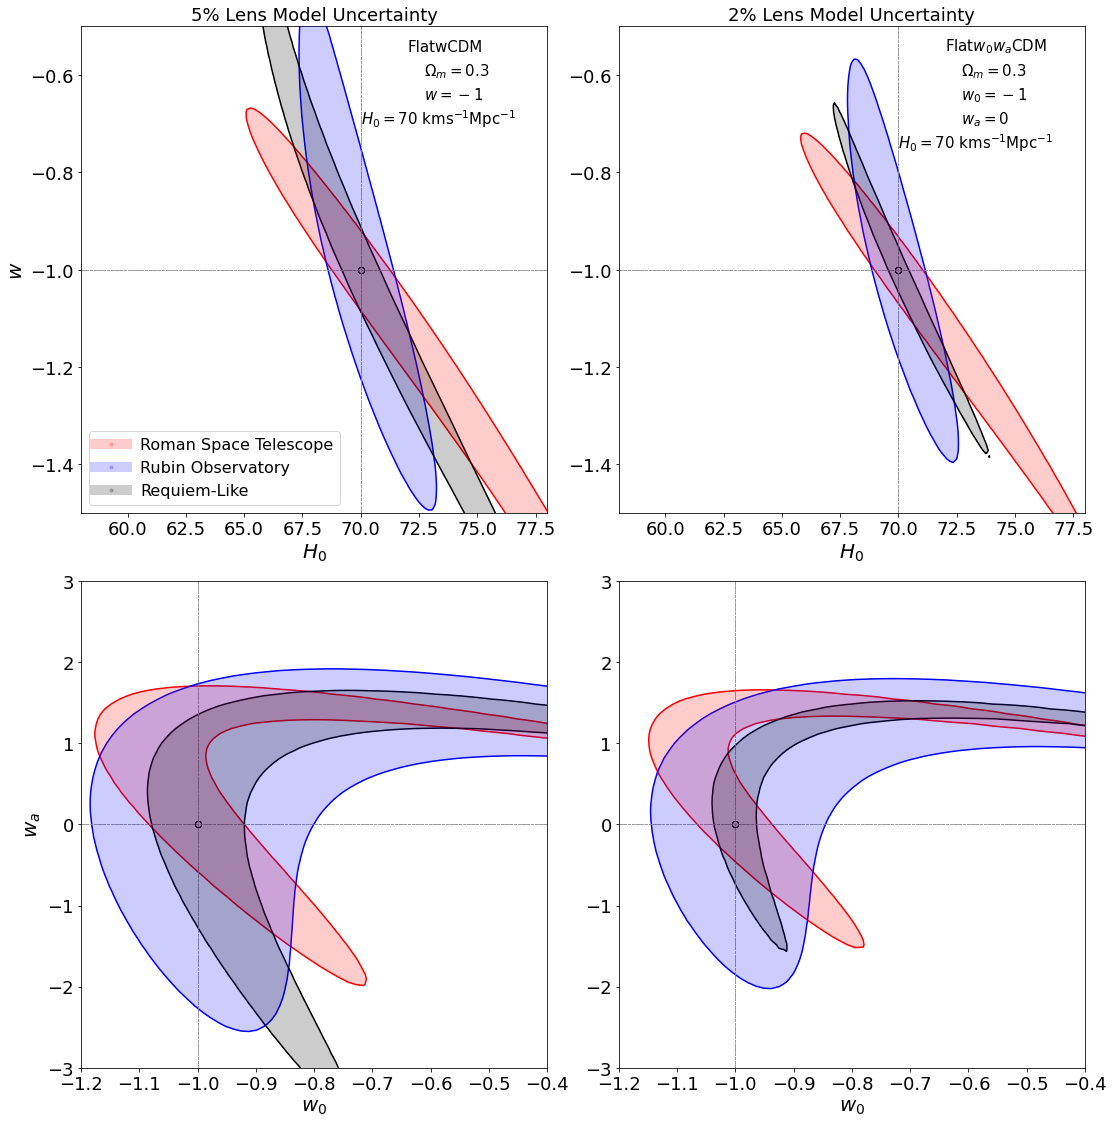

In [8]:
####Combined hw, w0wa:
import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(2, 2)
sharex=False
sharey=True
axes=[]

for i in range(2):
    temp=[]
    for j in range(2):
        temp.append(fig.add_subplot(gs[i,j]))
        if sharex and j>0:
            temp[-1].get_shared_x_axes().join(temp[0], temp[-1])
        if sharey and j>0:
            temp[-1].get_shared_y_axes().join(temp[0], temp[-1])
    axes.append(temp)



fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
lines=[]
line_names=[]
ax=None
colors=['red','blue','k']
i=0
survey_dict={'ngrst':[ngrst_5,ngrst_2],'lsst':[lsst_5,lsst_2],'req':[req_5,req_2]}
for survey in ['ngrst','lsst','req']:
    axes[0][1],line,line_name=survey_dict[survey][1].plot_survey_contour(['H0','w'],filled=True,fom=False,
                                                 math_labels=[r'$H_0$',r'$w$'],ax=axes[0][1],
                                               confidence=[.68],alphas=[.2],color=colors[i])
    axes[0][0],line,line_name=survey_dict[survey][0].plot_survey_contour(['H0','w'],filled=True,fom=False,
                                                 math_labels=[r'$H_0$',r'$w$'],ax=axes[0][0],
                                               confidence=[.68],alphas=[.2],color=colors[i])
    
    axes[1][0],line,line_name=survey_dict[survey][0].plot_survey_contour(['w0','wa'],filled=True,fom=False,
                                                 math_labels=[r'$w_0$',r'$w_a$'],ax=axes[1][0],
                                               confidence=[.68],alphas=[.2],color=colors[i])
    axes[1][1],line,line_name=survey_dict[survey][1].plot_survey_contour(['w0','wa'],filled=True,fom=False,
                                                 math_labels=[r'$w_0$',r'$w_a$'],ax=axes[1][1],
                                               confidence=[.68],alphas=[.2],color=colors[i])
    axes[0][1],line,line_name=survey_dict[survey][1].plot_survey_contour(['H0','w'],filled=False,fom=False,
                                                 math_labels=[r'$H_0$',r'$w$'],ax=axes[0][1],
                                               confidence=[.68],alphas=[.2],color=colors[i])
    axes[0][0],line,line_name=survey_dict[survey][0].plot_survey_contour(['H0','w'],filled=False,fom=False,
                                                 math_labels=[r'$H_0$',r'$w$'],ax=axes[0][0],
                                               confidence=[.68],alphas=[.2],color=colors[i])
    
    axes[1][0],line,line_name=survey_dict[survey][0].plot_survey_contour(['w0','wa'],filled=False,fom=False,
                                                 math_labels=[r'$w_0$',r'$w_a$'],ax=axes[1][0],
                                               confidence=[.68],alphas=[.2],color=colors[i])
    axes[1][1],line,line_name=survey_dict[survey][1].plot_survey_contour(['w0','wa'],filled=False,fom=False,
                                                 math_labels=[r'$w_0$',r'$w_a$'],ax=axes[1][1],
                                               confidence=[.68],alphas=[.2],color=colors[i])
    
    line_name=line_name.replace('Requiem','Requiem-Like')
    line_name=line_name.replace('Optimistic','')
    line_name=line_name.replace('Rubin','Rubin Observatory')
    
    i+=1
    lines.append(line)
    line_names.append(line_name)
axes[0][0].legend(lines,line_names,loc='lower left',fontsize=16)
ticklabelsize=18
axes[0][0].set_xlim(ax_lims['h'])
axes[0][1].set_xlim(ax_lims['h'])
axes[1][0].set_xlim(ax_lims['w0'])
axes[1][1].set_xlim(ax_lims['w0'])
axes[0][0].set_ylim(ax_lims['w'])
axes[0][1].set_ylim(ax_lims['w'])
axes[1][0].set_ylim(ax_lims['wa'])
axes[1][1].set_ylim(ax_lims['wa'])

axes[0][1].set_ylabel('')
axes[1][1].set_ylabel('')
for i in range(2):
    for j in range(2):
        
        for tick in axes[i][j].xaxis.get_major_ticks():
            tick.label.set_fontsize(ticklabelsize)
        for tick in axes[i][j].yaxis.get_major_ticks():
            tick.label.set_fontsize(ticklabelsize)
axes[0][0].set_title('5% Lens Model Uncertainty',fontsize=18)
axes[0][1].set_title('2% Lens Model Uncertainty',fontsize=18)

axes[0][0].set_xlim((58,78))
axes[0][1].set_xlim((58,78))
axes[1][0].set_xlim((-1.2,-.4))
axes[1][1].set_xlim((-1.2,-.4))


axes[0][0].annotate('FlatwCDM',
                       (.7,.95),xycoords='axes fraction',fontsize=15)
axes[0][0].annotate(r'$\Omega_m=0.3$',
                       (.735,.9),xycoords='axes fraction',fontsize=15)
axes[0][0].annotate(r'$w=-1$',
                       (.735,.85),xycoords='axes fraction',fontsize=15)
axes[0][0].annotate(r'$H_0=70 \ \rm{kms}^{-1}\rm{Mpc}^{-1}$',
                       (.6,.8),xycoords='axes fraction',fontsize=15)
axes[0][1].annotate('Flat'+'$w_0w_a$'+'CDM',
                       (.7,.95),xycoords='axes fraction',fontsize=15)
axes[0][1].annotate(r'$\Omega_m=0.3$',
                       (.735,.9),xycoords='axes fraction',fontsize=15)
axes[0][1].annotate(r'$w_0=-1$',
                       (.735,.85),xycoords='axes fraction',fontsize=15)
axes[0][1].annotate(r'$w_a=0$',
                       (.735,.8),xycoords='axes fraction',fontsize=15)
axes[0][1].annotate(r'$H_0=70 \ \rm{kms}^{-1}\rm{Mpc}^{-1}$',
                       (.6,.75),xycoords='axes fraction',fontsize=15)

#axes[1][0].annotate('Flat'+'$w_0w_a$'+'CDM ('+r'$\Omega_m=0.3, \ w_0=-1, \ w_a=0 \ H_0=70\rm{kms}^{-1}\rm{Mpc}^{-1}$)',
                       #(.8,.9),xycoords='axes fraction',fontsize=16)

plt.savefig("../../Paper/Figures/snrequiem_hw_w0wa_apples_to_lsst_ngrst_4panel.pdf")
plt.tight_layout()
plt.show()